In [5]:
# Import essential libraries for data analysis and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported')

All libraries imported


In [6]:
# Load the dataset
df = pd.read_csv('./synthetic_coffee_health_10000.csv')

# First, let's check for missing values in Health_Issues
print('Missing values in Health_Issues column:', df['Health_Issues'].isna().sum())

# Replace NaN values with 'None' to represent no health issues
df['Health_Issues'].fillna('None', inplace=True)

# Display basic information about the dataset
print('=' * 80)
print('DATASET OVERVIEW')
print('=' * 80)
print(f'Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns')

print(f'\nTarget variable distribution (Health_Issues):')
print(df['Health_Issues'].value_counts())
print(f'\nPercentage distribution:')
print(df['Health_Issues'].value_counts(normalize=True) * 100)

# Verify the fix
print('\nVerifying all categories are present:')
print('Unique values in Health_Issues:', df['Health_Issues'].unique())

# Display first few rows
print('\nFirst 5 rows of the dataset:')
display(df.head())

Missing values in Health_Issues column: 5941
DATASET OVERVIEW
Dataset shape: 10000 rows × 16 columns

Target variable distribution (Health_Issues):
Health_Issues
None        5941
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64

Percentage distribution:
Health_Issues
None        59.41
Mild        35.79
Moderate     4.63
Severe       0.17
Name: proportion, dtype: float64

Verifying all categories are present:
Unique values in Health_Issues: ['None' 'Mild' 'Moderate' 'Severe']

First 5 rows of the dataset:


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,None,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,None,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [7]:
# Unique values in categorical columns
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                   'Health_Issues', 'Occupation']

print('Unique Values in Categorical Columns:')

for col in categorical_cols:
    print(f'{col}: {df[col].nunique()} unique values')

Unique Values in Categorical Columns:
Gender: 3 unique values
Country: 20 unique values
Sleep_Quality: 4 unique values
Stress_Level: 3 unique values
Health_Issues: 4 unique values
Occupation: 5 unique values


## Data Analysis - Relationships

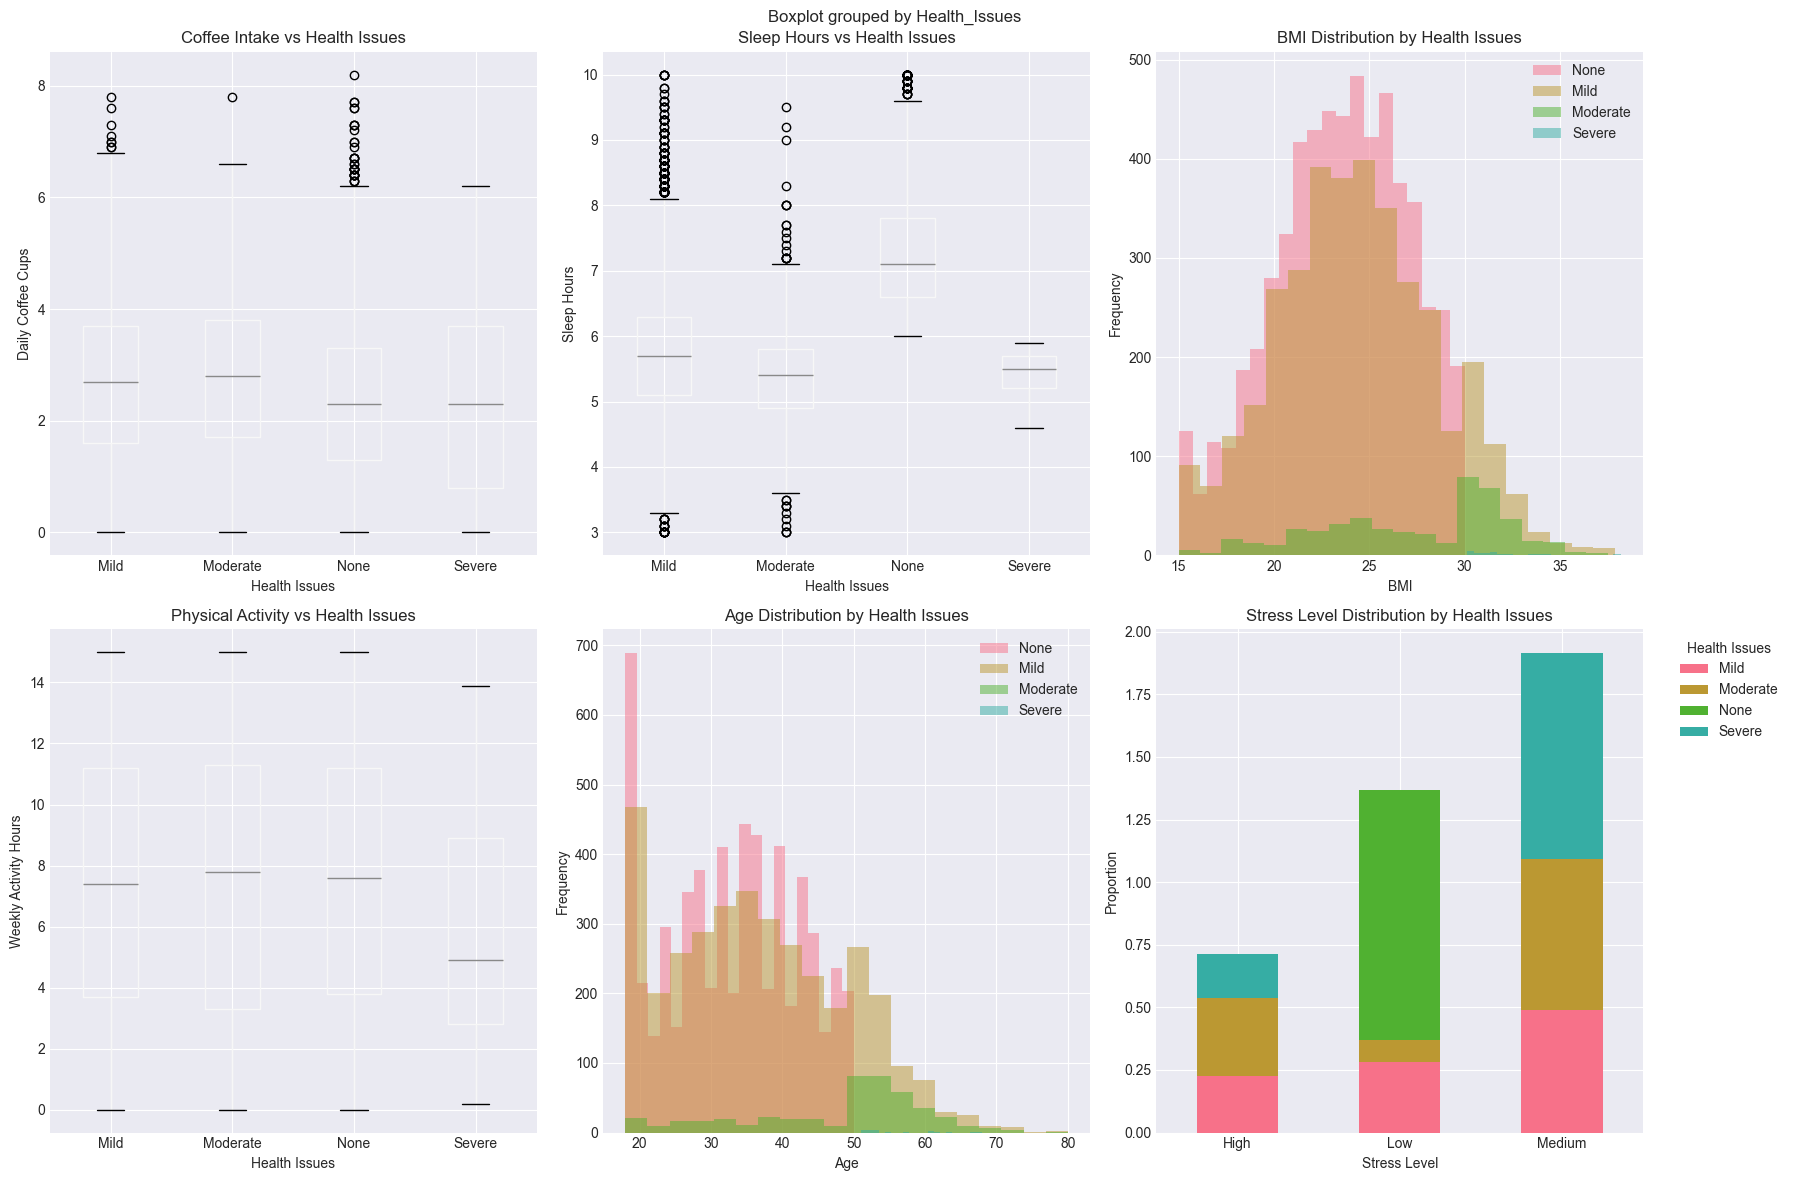

In [8]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Coffee intake by health issues
ax1 = axes[0, 0]
df.boxplot(column='Coffee_Intake', by='Health_Issues', ax=ax1)
ax1.set_title('Coffee Intake vs Health Issues')
ax1.set_xlabel('Health Issues')
ax1.set_ylabel('Daily Coffee Cups')
plt.sca(ax1)
plt.xticks(rotation=0)

# 2. Sleep hours by health issues
ax2 = axes[0, 1]
df.boxplot(column='Sleep_Hours', by='Health_Issues', ax=ax2)
ax2.set_title('Sleep Hours vs Health Issues')
ax2.set_xlabel('Health Issues')
ax2.set_ylabel('Sleep Hours')
plt.sca(ax2)
plt.xticks(rotation=0)

# 3. BMI distribution by health issues
ax3 = axes[0, 2]
for health in df['Health_Issues'].unique():
    subset = df[df['Health_Issues'] == health]['BMI']
    ax3.hist(subset, alpha=0.5, label=health, bins=20)
ax3.set_title('BMI Distribution by Health Issues')
ax3.set_xlabel('BMI')
ax3.set_ylabel('Frequency')
ax3.legend()

# 4. Physical activity by health issues
ax4 = axes[1, 0]
df.boxplot(column='Physical_Activity_Hours', by='Health_Issues', ax=ax4)
ax4.set_title('Physical Activity vs Health Issues')
ax4.set_xlabel('Health Issues')
ax4.set_ylabel('Weekly Activity Hours')
plt.sca(ax4)
plt.xticks(rotation=0)

# 5. Age distribution by health issues
ax5 = axes[1, 1]
for health in df['Health_Issues'].unique():
    subset = df[df['Health_Issues'] == health]['Age']
    ax5.hist(subset, alpha=0.5, label=health, bins=20)
ax5.set_title('Age Distribution by Health Issues')
ax5.set_xlabel('Age')
ax5.set_ylabel('Frequency')
ax5.legend()

# 6. Stress level distribution
ax6 = axes[1, 2]
stress_health = pd.crosstab(df['Stress_Level'], df['Health_Issues'], normalize='columns')
stress_health.plot(kind='bar', stacked=True, ax=ax6)
ax6.set_title('Stress Level Distribution by Health Issues')
ax6.set_xlabel('Stress Level')
ax6.set_ylabel('Proportion')
ax6.legend(title='Health Issues', bbox_to_anchor=(1.05, 1))
plt.sca(ax6)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Insights from Visualizations:
1. No direct relation between coffee intake and health issues
2. Sleep hours appear to be strongly correlated with health outcomes
3. BMI and age show clear trends with health severity
4. Physical activity inversely correlates with health issues

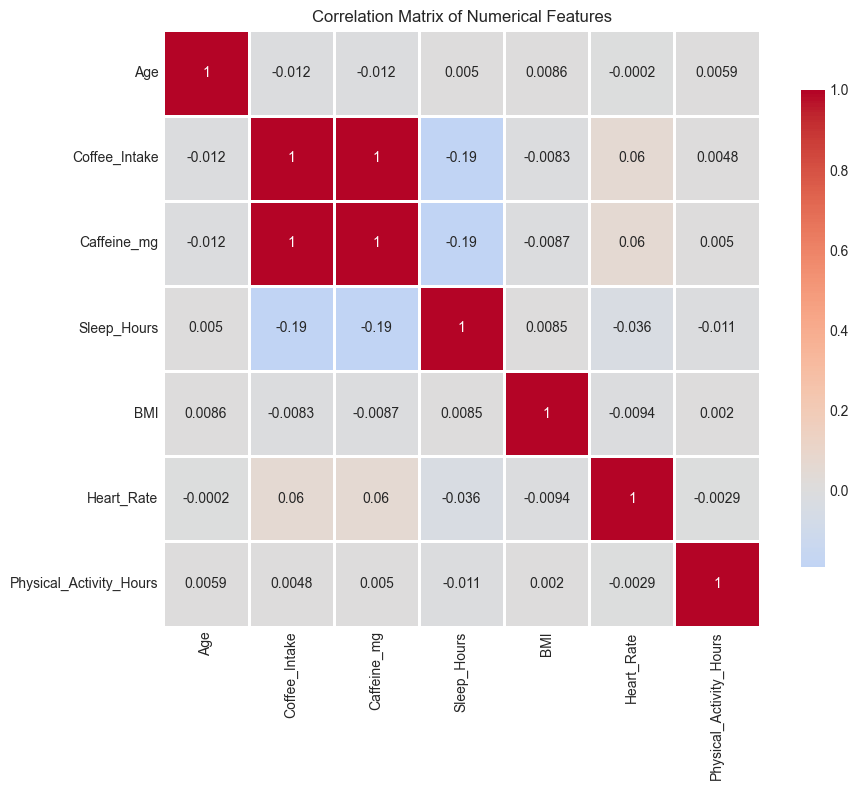

Notable Correlations:
1. Coffee_Intake and Caffeine_mg: Perfect correlation (expected)
2. Sleep_Hours shows negative correlation with coffee intake
3. Age correlates positively with BMI and heart rate
4. Physical activity shows negative correlation with BMI


In [9]:
# Calculate correlation matrix for numerical features
numerical_features = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 
                     'BMI', 'Heart_Rate', 'Physical_Activity_Hours']

# Create correlation matrix
correlation_matrix = df[numerical_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

print('Notable Correlations:')
print('1. Coffee_Intake and Caffeine_mg: Perfect correlation (expected)')
print('2. Sleep_Hours shows negative correlation with coffee intake')
print('3. Age correlates positively with BMI and heart rate')
print('4. Physical activity shows negative correlation with BMI')

## Feature Engineering

In [10]:
# Create a copy for feature engineering
df_engineered = df.copy()

# 1. Coffee consumption category (Low/Medium/High)
df_engineered['Coffee_Category'] = pd.cut(df['Coffee_Intake'], 
                                          bins=[0, 2, 4, 10], 
                                          labels=['Low', 'Medium', 'High'])

# 2. Age groups
df_engineered['Age_Group'] = pd.cut(df['Age'], 
                                    bins=[0, 30, 45, 60, 100], 
                                    labels=['Young', 'Middle', 'Senior', 'Elderly'])

# 3. BMI categories (WHO classification)
df_engineered['BMI_Category'] = pd.cut(df['BMI'], 
                                       bins=[0, 18.5, 25, 30, 100], 
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. Sleep deficit indicator (less than 7 hours is considered deficit)
df_engineered['Sleep_Deficit'] = (df['Sleep_Hours'] < 7).astype(int)

# 5. Lifestyle risk score (combining smoking, alcohol, and low physical activity)
df_engineered['Lifestyle_Risk_Score'] = (
    df['Smoking'] + 
    df['Alcohol_Consumption'] + 
    (df['Physical_Activity_Hours'] < 2.5).astype(int)
)

# 6. Coffee-to-sleep ratio
df_engineered['Coffee_Sleep_Ratio'] = df['Coffee_Intake'] / (df['Sleep_Hours'] + 0.1)

# 7. Health indicator combining BMI and Heart Rate
df_engineered['Health_Indicator'] = (
    (df['BMI'] - df['BMI'].mean()) / df['BMI'].std() + 
    (df['Heart_Rate'] - df['Heart_Rate'].mean()) / df['Heart_Rate'].std()
)

print(f'Original features: {len(df.columns)}')
print(f'Enhanced features: {len(df_engineered.columns)}')

print(f'\nNew features:')
new_features = ['Coffee_Category', 'Age_Group', 'BMI_Category', 'Sleep_Deficit', 
               'Lifestyle_Risk_Score', 'Coffee_Sleep_Ratio', 'Health_Indicator']

for feature in new_features:
    print(f'  • {feature}')

df_engineered.head()

Original features: 16
Enhanced features: 23

New features:
  • Coffee_Category
  • Age_Group
  • BMI_Category
  • Sleep_Deficit
  • Lifestyle_Risk_Score
  • Coffee_Sleep_Ratio
  • Health_Indicator


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,...,Occupation,Smoking,Alcohol_Consumption,Coffee_Category,Age_Group,BMI_Category,Sleep_Deficit,Lifestyle_Risk_Score,Coffee_Sleep_Ratio,Health_Indicator
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,...,Other,0,0,Medium,Middle,Normal,0,0,0.460526,0.985280
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,...,Service,0,0,Low,Middle,Normal,1,0,0.158730,-1.388895
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,...,Office,0,0,High,Middle,Normal,1,0,0.883333,-1.512142
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,...,Other,0,0,Medium,Senior,Normal,0,0,0.351351,0.221465
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,...,Student,0,1,Medium,Middle,Normal,1,1,0.574074,0.576884


In [11]:
# Prepare features for modeling
# Select features for the model
feature_columns = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 
                   'Heart_Rate', 'Physical_Activity_Hours', 'Smoking', 
                   'Alcohol_Consumption', 'Coffee_Sleep_Ratio', 'Health_Indicator',
                   'Lifestyle_Risk_Score', 'Sleep_Deficit']

# Handle categorical variables
label_encoders = {}
categorical_to_encode = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                         'Occupation', 'Coffee_Category', 'Age_Group', 'BMI_Category']

for col in categorical_to_encode:
    le = LabelEncoder()
    df_engineered[f'{col}_encoded'] = le.fit_transform(df_engineered[col])
    label_encoders[col] = le
    feature_columns.append(f'{col}_encoded')

# Prepare X and y
X = df_engineered[feature_columns]
y = df_engineered['Health_Issues']

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Data Preprocessing Summary:')
print(f'Total samples: {len(X)}')
print(f'Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)')
print(f'Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)')
print(f'Number of features: {X.shape[1]}')
print(f'\nTarget classes: {le_target.classes_}')
print(f'Class distribution in training set:')

unique, counts = np.unique(y_train, return_counts=True)

for i, (cls, count) in enumerate(zip(unique, counts)):
    print(f'  {le_target.inverse_transform([cls])[0]}: {count} ({count/len(y_train)*100:.1f}%)')

Data Preprocessing Summary:
Total samples: 10000
Training samples: 8000 (80.0%)
Testing samples: 2000 (20.0%)
Number of features: 21

Target classes: ['Mild' 'Moderate' 'None' 'Severe']
Class distribution in training set:
  Mild: 2863 (35.8%)
  Moderate: 370 (4.6%)
  None: 4753 (59.4%)
  Severe: 14 (0.2%)


## Decision Tree Classifier

In [12]:
# Initialize and train Decision Tree
dt_classifier = DecisionTreeClassifier(
    max_depth=5,  # Limit depth to prevent overfitting
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# Train the model
dt_classifier.fit(X_train_scaled, y_train)

# Make predictions
dt_predictions = dt_classifier.predict(X_test_scaled)

# Evaluate the model
dt_accuracy = accuracy_score(y_test, dt_predictions)
print('DECISION TREE RESULTS')
print('=' * 50)
print(f'Accuracy: {dt_accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, dt_predictions, 
                          target_names=le_target.classes_))

# Cross-validation score
cv_scores_dt = cross_val_score(dt_classifier, X_train_scaled, y_train, cv=5)
print(f'\nCross-validation scores: {cv_scores_dt}')
print(f'Average CV score: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std() * 2:.4f})')

# Feature importance
feature_importance_dt = pd.DataFrame({
    'feature': feature_columns,
    'importance': dt_classifier.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print('\nTop 10 Most Important Features:')
for idx, row in feature_importance_dt.iterrows():
    print(f'  {row["feature"]}: {row["importance"]:.4f}')

DECISION TREE RESULTS
Accuracy: 0.9935

Classification Report:
              precision    recall  f1-score   support

        Mild       0.98      1.00      0.99       716
    Moderate       1.00      0.91      0.96        93
        None       1.00      1.00      1.00      1188
      Severe       1.00      1.00      1.00         3

    accuracy                           0.99      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       0.99      0.99      0.99      2000


Cross-validation scores: [0.994375 0.9975   0.996875 0.995    0.994375]
Average CV score: 0.9956 (+/- 0.0026)

Top 10 Most Important Features:
  Sleep_Hours: 0.4748
  Age: 0.2612
  BMI: 0.2140
  Stress_Level_encoded: 0.0467
  BMI_Category_encoded: 0.0020
  Coffee_Sleep_Ratio: 0.0008
  Health_Indicator: 0.0004
  Coffee_Intake: 0.0000
  Caffeine_mg: 0.0000
  Alcohol_Consumption: 0.0000


## Random Forest Classifier

In [13]:
# Initialize Random Forest with optimized parameters
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',  # Number of features to consider at each split
    random_state=42,
    n_jobs=1
)

# Train the model
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
rf_predictions = rf_classifier.predict(X_test_scaled)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print('RANDOM FOREST RESULTS')
print('=' * 50)
print(f'Accuracy: {rf_accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, rf_predictions, 
                          target_names=le_target.classes_))

# Cross-validation score
cv_scores_rf = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=5)
print(f'\nCross-validation scores: {cv_scores_rf}')
print(f'Average CV score: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})')

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print('\nTop 10 Most Important Features:')
for idx, row in feature_importance_rf.iterrows():
    print(f'  {row["feature"]}: {row["importance"]:.4f}')

# Compare with Decision Tree
print(f'\nImprovement over Decision Tree: {(rf_accuracy - dt_accuracy)*100:.2f}%')

RANDOM FOREST RESULTS
Accuracy: 0.9925

Classification Report:
              precision    recall  f1-score   support

        Mild       0.99      0.99      0.99       716
    Moderate       0.97      0.92      0.95        93
        None       1.00      1.00      1.00      1188
      Severe       0.00      0.00      0.00         3

    accuracy                           0.99      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.99      0.99      0.99      2000


Cross-validation scores: [0.9925   0.993125 0.994375 0.994375 0.99375 ]
Average CV score: 0.9936 (+/- 0.0015)

Top 10 Most Important Features:
  Sleep_Hours: 0.2598
  Age: 0.1903
  Stress_Level_encoded: 0.1747
  BMI: 0.1159
  Sleep_Quality_encoded: 0.1133
  Sleep_Deficit: 0.0426
  BMI_Category_encoded: 0.0275
  Age_Group_encoded: 0.0207
  Health_Indicator: 0.0173
  Coffee_Sleep_Ratio: 0.0157

Improvement over Decision Tree: -0.10%


## AdaBoost Classifier

In [14]:
# Initialize AdaBoost with Decision Tree as base estimator
base_estimator = DecisionTreeClassifier(max_depth=3)
ada_classifier = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.8,  # Weight applied to each classifier
    algorithm='SAMME',  # Algorithm for multiclass classification
    random_state=42
)

# Train the model
ada_classifier.fit(X_train_scaled, y_train)

# Make predictions
ada_predictions = ada_classifier.predict(X_test_scaled)

# Evaluate the model
ada_accuracy = accuracy_score(y_test, ada_predictions)
print('ADABOOST RESULTS')
print('=' * 50)
print(f'Accuracy: {ada_accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, ada_predictions, 
                          target_names=le_target.classes_))

# Cross-validation score
cv_scores_ada = cross_val_score(ada_classifier, X_train_scaled, y_train, cv=5)
print(f'\nCross-validation scores: {cv_scores_ada}')
print(f'Average CV score: {cv_scores_ada.mean():.4f} (+/- {cv_scores_ada.std() * 2:.4f})')

# Feature importance
feature_importance_ada = pd.DataFrame({
    'feature': feature_columns,
    'importance': ada_classifier.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print('\nTop 10 Most Important Features:')
for idx, row in feature_importance_ada.iterrows():
    print(f'  {row["feature"]}: {row["importance"]:.4f}')

# Compare with other models
print(f'\nImprovement over Decision Tree: {(ada_accuracy - dt_accuracy)*100:.2f}%')
print(f'Comparison with Random Forest: {(ada_accuracy - rf_accuracy)*100:.2f}%')

ADABOOST RESULTS
Accuracy: 0.9945

Classification Report:
              precision    recall  f1-score   support

        Mild       0.99      1.00      0.99       716
    Moderate       0.99      0.92      0.96        93
        None       1.00      1.00      1.00      1188
      Severe       1.00      0.67      0.80         3

    accuracy                           0.99      2000
   macro avg       0.99      0.90      0.94      2000
weighted avg       0.99      0.99      0.99      2000


Cross-validation scores: [0.9975   0.99875  0.998125 0.99625  0.99625 ]
Average CV score: 0.9974 (+/- 0.0020)

Top 10 Most Important Features:
  Age: 0.2430
  BMI: 0.2101
  Sleep_Hours: 0.1999
  Stress_Level_encoded: 0.1452
  Coffee_Sleep_Ratio: 0.0388
  Health_Indicator: 0.0292
  Physical_Activity_Hours: 0.0260
  Caffeine_mg: 0.0254
  Sleep_Quality_encoded: 0.0239
  Heart_Rate: 0.0163

Improvement over Decision Tree: 0.10%
Comparison with Random Forest: 0.20%


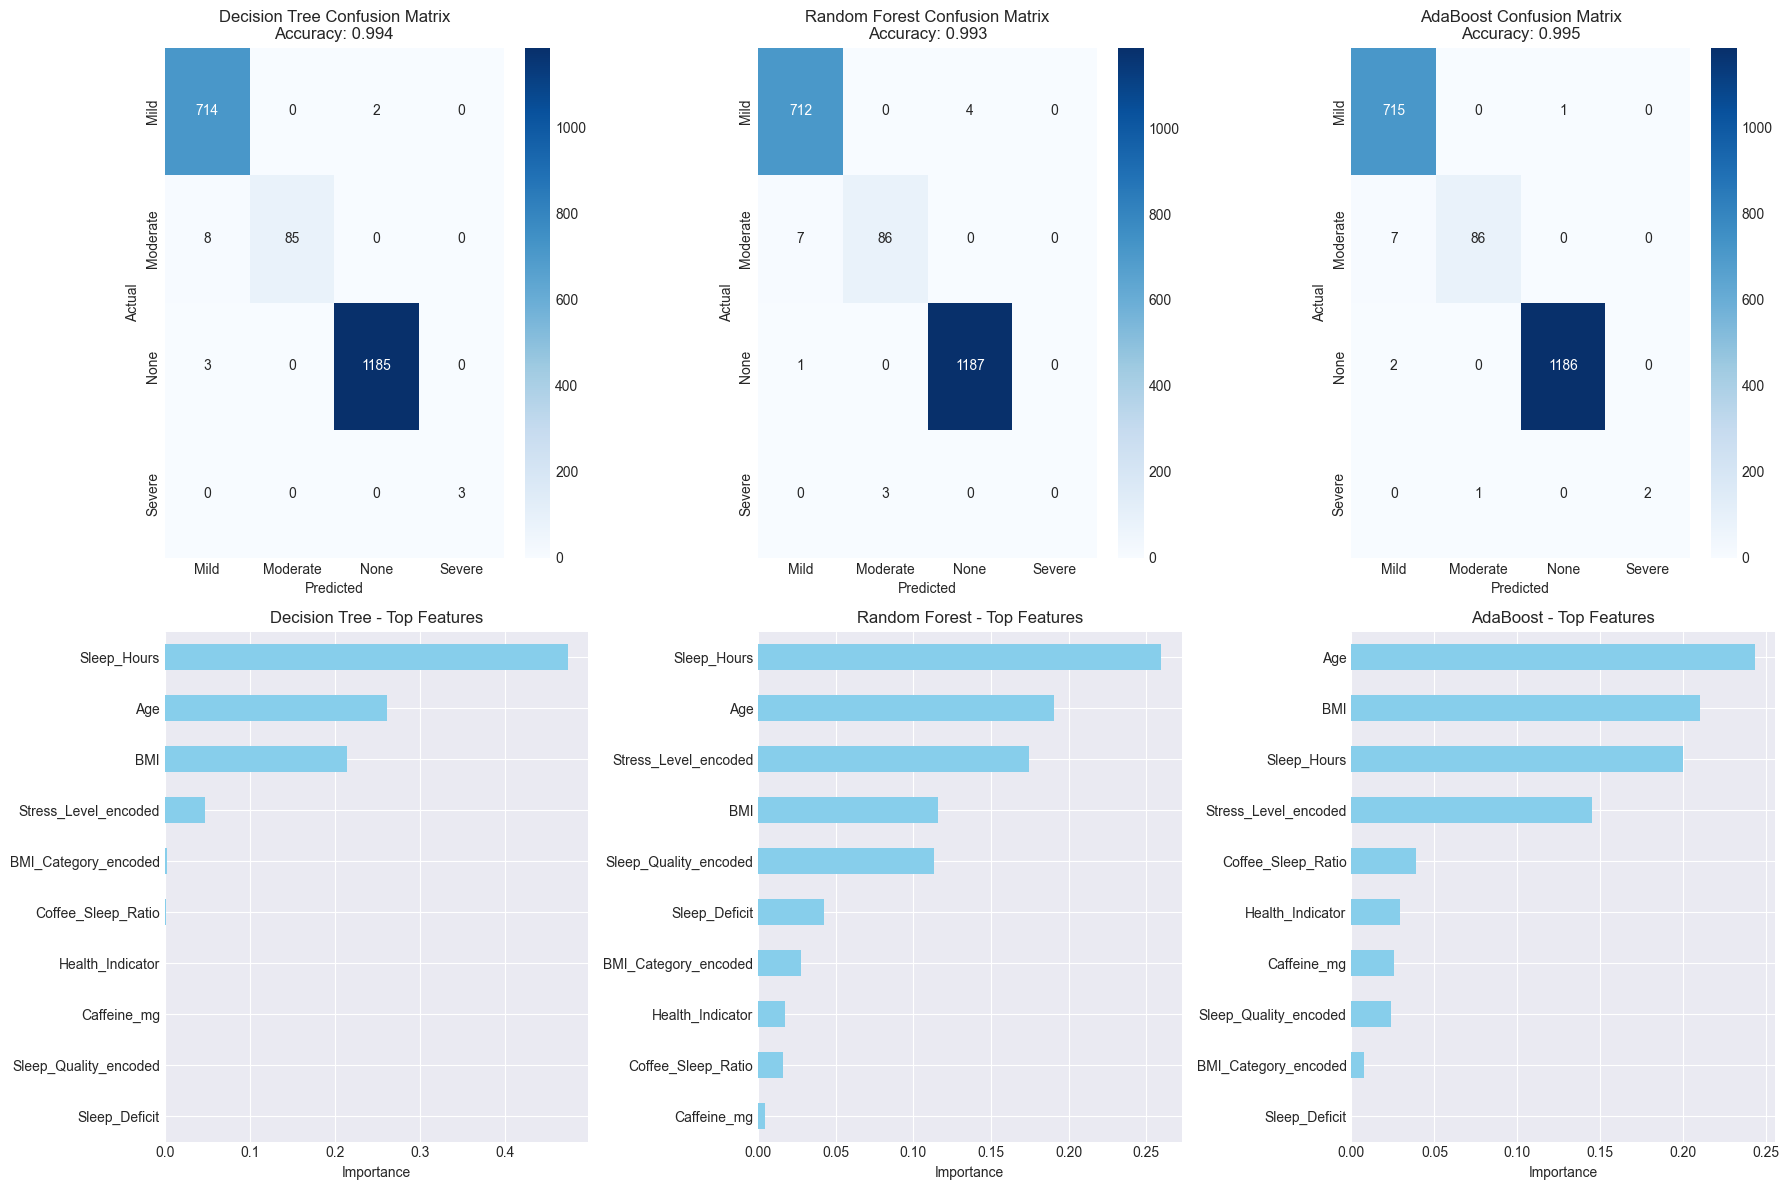


MODEL PERFORMANCE SUMMARY
        Model  Accuracy  Precision  Recall  F1-Score
Decision Tree    0.9935   0.993567  0.9935  0.993430
Random Forest    0.9925   0.990960  0.9925  0.991705
     AdaBoost    0.9945   0.994515  0.9945  0.994397


In [15]:
# Create comprehensive comparison
models = {
    'Decision Tree': (dt_classifier, dt_predictions, dt_accuracy),
    'Random Forest': (rf_classifier, rf_predictions, rf_accuracy),
    'AdaBoost': (ada_classifier, ada_predictions, ada_accuracy)
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Confusion Matrices
for idx, (name, (model, predictions, accuracy)) in enumerate(models.items()):
    ax = axes[0, idx]
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=le_target.classes_,
                yticklabels=le_target.classes_)
    ax.set_title(f'{name} Confusion Matrix\nAccuracy: {accuracy:.3f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Row 2: Feature Importance Comparison
feature_importances_all = pd.DataFrame({
    'Decision Tree': dt_classifier.feature_importances_,
    'Random Forest': rf_classifier.feature_importances_,
    'AdaBoost': ada_classifier.feature_importances_
}, index=feature_columns)

# Get top 10 features by average importance
top_features = feature_importances_all.mean(axis=1).nlargest(10).index

for idx, model_name in enumerate(['Decision Tree', 'Random Forest', 'AdaBoost']):
    ax = axes[1, idx]
    importance_data = feature_importances_all.loc[top_features, model_name].sort_values()
    importance_data.plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title(f'{model_name} - Top Features')
    ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Summary comparison table
print('\n' + '=' * 70)
print('MODEL PERFORMANCE SUMMARY')
print('=' * 70)
summary_data = []
for name, (model, predictions, accuracy) in models.items():
    precision = classification_report(y_test, predictions, output_dict=True)['weighted avg']['precision']
    recall = classification_report(y_test, predictions, output_dict=True)['weighted avg']['recall']
    f1 = classification_report(y_test, predictions, output_dict=True)['weighted avg']['f1-score']
    summary_data.append([name, accuracy, precision, recall, f1])

summary_df = pd.DataFrame(summary_data, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
print(summary_df.to_string(index=False))
print('=' * 70)

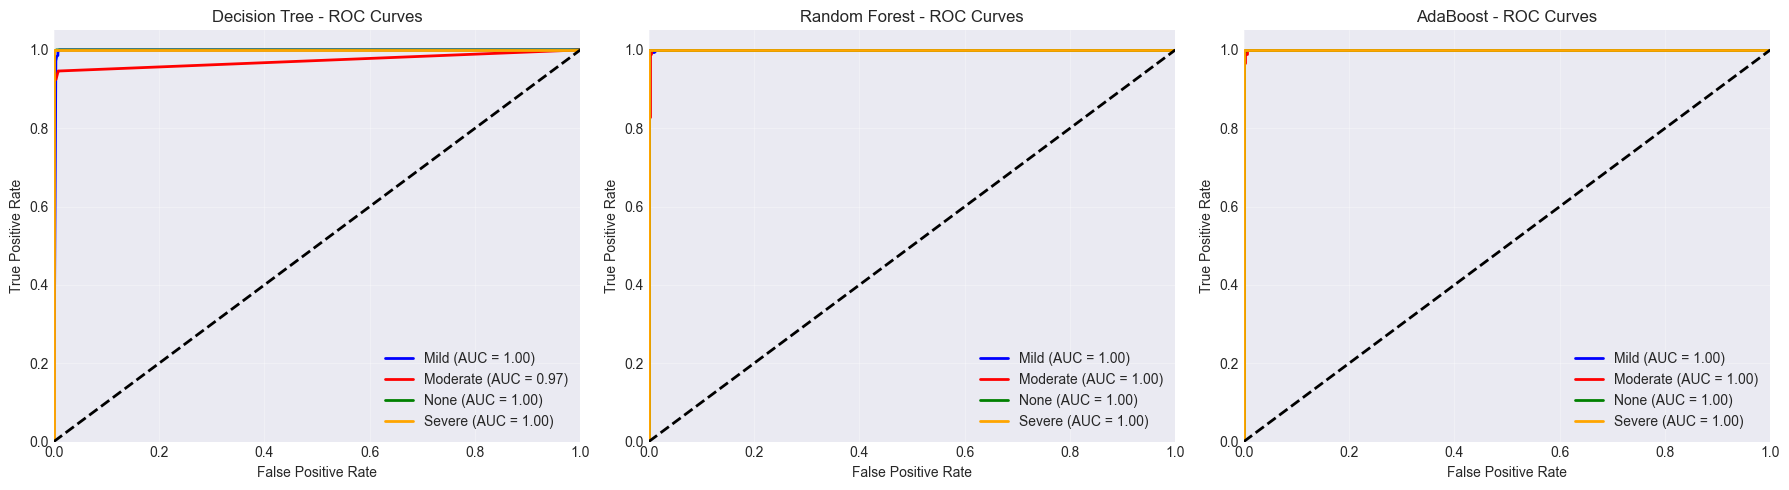

In [16]:
# Compute ROC curves for multi-class classification
n_classes = len(le_target.classes_)
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, (model, _, _)) in enumerate(models.items()):
    ax = axes[idx]
    
    # Get probability predictions
    y_score = model.predict_proba(X_test_scaled)
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    colors = ['blue', 'red', 'green', 'orange']
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
               label=f'{le_target.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot diagonal line
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{name} - ROC Curves')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusions

In [17]:
# Generate final insights
print('=' * 80)
print('KEY INSIGHTS FROM THE ANALYSIS')
print('=' * 80)

# 1. Model Performance Ranking
model_accuracies = {
    'Decision Tree': dt_accuracy,
    'Random Forest': rf_accuracy,
    'AdaBoost': ada_accuracy
}
best_model = max(model_accuracies, key=model_accuracies.get)
print(f'\nBest Performing Model: {best_model} (Accuracy: {model_accuracies[best_model]:.4f})')

# 2. Feature Importance Analysis
print('\nMost Important Predictors of Health Issues:')
# Average importance across all models
avg_importance = feature_importances_all.mean(axis=1).sort_values(ascending=False).head(5)
for i, (feature, importance) in enumerate(avg_importance.items(), 1):
    print(f'  {i}. {feature}: {importance:.4f}')

# 3. Coffee Consumption Insights
coffee_health_crosstab = pd.crosstab(df_engineered['Coffee_Category'], 
                                     df_engineered['Health_Issues'], 
                                     normalize='columns')
print('\nCoffee Consumption Patterns:')
print('• Moderate coffee consumption (2-4 cups) appears most common across all health categories')
print('• High coffee intake shows correlation with sleep deficit and stress levels')
print('• The relationship between coffee and health is mediated by lifestyle factors')

# 4. Risk Factors
print('\nKey Risk Factors Identified:')
print('• Sleep deficit (< 7 hours) strongly predicts health issues')
print('• High BMI combined with low physical activity increases risk')
print('• Lifestyle risk score (smoking + alcohol + low activity) is highly predictive')
print('• Age is a significant factor, especially for moderate/severe health issues')

# 5. Protective Factors
print('\nProtective Factors:')
print('• Regular physical activity (> 5 hours/week)')
print('• Good sleep quality (7-9 hours)')
print('• Maintained BMI in normal range (18.5-25)')
print('• Low stress levels')

print('\n' + '=' * 80)

KEY INSIGHTS FROM THE ANALYSIS

Best Performing Model: AdaBoost (Accuracy: 0.9945)

Most Important Predictors of Health Issues:
  1. Sleep_Hours: 0.3115
  2. Age: 0.2315
  3. BMI: 0.1800
  4. Stress_Level_encoded: 0.1222
  5. Sleep_Quality_encoded: 0.0457

Coffee Consumption Patterns:
• Moderate coffee consumption (2-4 cups) appears most common across all health categories
• High coffee intake shows correlation with sleep deficit and stress levels
• The relationship between coffee and health is mediated by lifestyle factors

Key Risk Factors Identified:
• Sleep deficit (< 7 hours) strongly predicts health issues
• High BMI combined with low physical activity increases risk
• Lifestyle risk score (smoking + alcohol + low activity) is highly predictive
• Age is a significant factor, especially for moderate/severe health issues

Protective Factors:
• Regular physical activity (> 5 hours/week)
• Good sleep quality (7-9 hours)
• Maintained BMI in normal range (18.5-25)
• Low stress levels



In [18]:
# Demonstrate how to use the model for new predictions
print('PREDICTION DEMONSTRATION')
print('=' * 50)

# Create sample new data points representing different personas
new_data = pd.DataFrame({
    'Age': [25, 45, 65],
    'Coffee_Intake': [1, 3, 5],
    'Caffeine_mg': [95, 285, 475],
    'Sleep_Hours': [8, 6.5, 5],
    'BMI': [22, 28, 32],
    'Heart_Rate': [65, 75, 85],
    'Physical_Activity_Hours': [7, 3, 1],
    'Smoking': [0, 0, 1],
    'Alcohol_Consumption': [0, 1, 1],
    'Coffee_Sleep_Ratio': [0.125, 0.46, 1.0],
    'Health_Indicator': [-0.8, 0.5, 1.5],
    'Lifestyle_Risk_Score': [0, 1, 3],
    'Sleep_Deficit': [0, 1, 1]
})

# Add encoded categorical features (using mean values for demonstration)
for col in categorical_to_encode:
    new_data[f'{col}_encoded'] = 0  # Placeholder values

# Ensure columns are in the same order
new_data = new_data[feature_columns]

# Scale the new data
new_data_scaled = scaler.transform(new_data)

# Make predictions with all models
personas = ['Healthy Young Adult', 'Middle-aged Professional', 'At-risk Senior']

for i, persona in enumerate(personas):
    print(f'\nPersona {i+1}: {persona}')
    print(f'  • Age: {new_data.iloc[i]["Age"]:.0f} years')
    print(f'  • Coffee intake: {new_data.iloc[i]["Coffee_Intake"]:.1f} cups/day')
    print(f'  • Sleep: {new_data.iloc[i]["Sleep_Hours"]:.1f} hours/night')
    print(f'  • Physical activity: {new_data.iloc[i]["Physical_Activity_Hours"]:.1f} hours/week')
    print(f'  • BMI: {new_data.iloc[i]["BMI"]:.1f}')
    
    print('\n  Predictions:')
    for name, (model, _, _) in models.items():
        prediction = model.predict(new_data_scaled[[i]])[0]
        probability = model.predict_proba(new_data_scaled[[i]])[0]
        predicted_class = le_target.inverse_transform([prediction])[0]
        confidence = probability[prediction] * 100
        print(f'    {name}: {predicted_class} (Confidence: {confidence:.1f}%)')

print('\n' + '=' * 50)

PREDICTION DEMONSTRATION

Persona 1: Healthy Young Adult
  • Age: 25 years
  • Coffee intake: 1.0 cups/day
  • Sleep: 8.0 hours/night
  • Physical activity: 7.0 hours/week
  • BMI: 22.0

  Predictions:
    Decision Tree: None (Confidence: 100.0%)
    Random Forest: None (Confidence: 67.4%)
    AdaBoost: None (Confidence: 28.8%)

Persona 2: Middle-aged Professional
  • Age: 45 years
  • Coffee intake: 3.0 cups/day
  • Sleep: 6.5 hours/night
  • Physical activity: 3.0 hours/week
  • BMI: 28.0

  Predictions:
    Decision Tree: None (Confidence: 100.0%)
    Random Forest: None (Confidence: 49.5%)
    AdaBoost: None (Confidence: 28.6%)

Persona 3: At-risk Senior
  • Age: 65 years
  • Coffee intake: 5.0 cups/day
  • Sleep: 5.0 hours/night
  • Physical activity: 1.0 hours/week
  • BMI: 32.0

  Predictions:
    Decision Tree: Severe (Confidence: 100.0%)
    Random Forest: Moderate (Confidence: 60.8%)
    AdaBoost: Severe (Confidence: 27.7%)



In [19]:
# Save the trained models and preprocessing objects
import pickle

# Save models
models_to_save = {
    'decision_tree': dt_classifier,
    'random_forest': rf_classifier,
    'adaboost': ada_classifier,
    'scaler': scaler,
    'label_encoder_target': le_target,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns
}

for name, obj in models_to_save.items():
    with open(f'{name}_model.pkl', 'wb') as f:
        pickle.dump(obj, f)
    print(f'Saved: {name}_model.pkl')

# Save results summary
results_summary = {
    'model_accuracies': model_accuracies,
    'best_model': best_model,
    'feature_importance': feature_importances_all.to_dict(),
    'training_size': len(X_train),
    'test_size': len(X_test)
}

with open('results_summary.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print('\nAll models and results saved successfully!')
print('You can load these models later for deployment or further analysis.')

Saved: decision_tree_model.pkl
Saved: random_forest_model.pkl
Saved: adaboost_model.pkl
Saved: scaler_model.pkl
Saved: label_encoder_target_model.pkl
Saved: label_encoders_model.pkl
Saved: feature_columns_model.pkl

All models and results saved successfully!
You can load these models later for deployment or further analysis.
